# Notebook to plot the continuous-time dynamics of the FAQL model for four matrix games

In [1]:
# import general libraries
import numpy as np
from scipy.signal import periodogram
from scipy.signal import welch
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
# import from the file multiplayer_prisoners_dilemma.py
from multiplayer_prisoners_dilemma import QLearningAgent
from multiplayer_prisoners_dilemma import Game
from multiplayer_prisoners_dilemma import Simulation

In [2]:
# define the reward function for the two player prisoner's dilemma
def reward_matrix_for_two_player_PD(action_vector, player_id, return_title=False):
    # reward tensor R_i_a0_a1. first index is the agent, second index is the action taken by the agent 1, third index is the action taken by the agent 2
    S, P, R, T = 0, 1, 3, 5
    R_i_a1_a2 = np.array([[[R, S], 
                        [T, P]],
                        [[R, T], 
                        [S, P]]])
    title = "Prisoner's Dilemma" 
    first_action = 'C'
    if return_title:
        return R_i_a1_a2[player_id, action_vector[0], action_vector[1]], title, first_action
    else:
        return R_i_a1_a2[player_id, action_vector[0], action_vector[1]]

# define the reward function for the two player matching pennies
def reward_matrix_for_two_player_MP(action_vector, player_id, return_title=False):
    # reward tensor R_i_a0_a1. first index is the agent, second index is the action taken by the agent 1, third index is the action taken by the agent 2
    R_i_a1_a2 = np.array([[[1, -0], 
                        [-0, 1]],
                        [[-0, 1], 
                        [1, -0]]])
    title = "Matching Pennies"
    first_action = 'H'
    if return_title:
        return R_i_a1_a2[player_id, action_vector[0], action_vector[1]], title, first_action
    else:
        return R_i_a1_a2[player_id, action_vector[0], action_vector[1]]

# define the reward function for the two player stag hunt
def reward_matrix_for_two_player_SH(action_vector, player_id, return_title=False):
    # reward tensor R_i_a0_a1. first index is the agent, second index is the action taken by the agent 1, third index is the action taken by the agent 2
    R_i_a1_a2 = np.array([[[4, 1], 
                        [3, 3]],
                        [[4, 3], 
                        [1, 3]]])
    title = "Stag Hunt"
    first_action = 'S'
    if return_title:
        return R_i_a1_a2[player_id, action_vector[0], action_vector[1]], title, first_action
    else:
        return R_i_a1_a2[player_id, action_vector[0], action_vector[1]]

# define the reward function for the two player bach or stravinsky
def reward_matrix_for_two_player_BS(action_vector, player_id, return_title=False):
    # reward tensor R_i_a0_a1. first index is the agent, second index is the action taken by the agent 1, third index is the action taken by the agent 2
    R_i_a1_a2 = np.array([[[3, 0], 
                        [0, 2]],
                        [[2, 0], 
                        [0, 3]]])
    title = "Bach or Stravinsky"
    first_action = 'B'
    if return_title:
        return R_i_a1_a2[player_id, action_vector[0], action_vector[1]], title, first_action
    else:
        return R_i_a1_a2[player_id, action_vector[0], action_vector[1]]

def calculate_fixed_point_policy_for_2x2_matrix_games(R_i_a0_a1, temperature):
    ''' 
    A function that calculates the fixed point policy for a 2x2 matrix game with two agents.
    In reference to the prisoner's dilemma, the notation of the action variables are C and D, but the function is general for any 2x2 matrix game,
    where the first action is indexed by 0 and the second action is indexed by 1.

    Input:
    - R_i_a0_a1: Reward tensor of shape (2, 2, 2) for two agents with two actions each
    - temperature: Temperature parameter that scales the logit function

    Output:
    - results: Fixed point policy for the two agents: [p_1_C, p_2_C]
    '''
    R_i_a0_a1 = R_i_a0_a1
    temperature = temperature
    # rewards for agent 1
    R_1_CC = R_i_a0_a1[0,0,0] # Reward for agent 1 if both agents choose action C
    R_1_CD = R_i_a0_a1[0,0,1] # Reward for agent 1 if agent 1 chooses C and agent 2 chooses D
    R_1_DC = R_i_a0_a1[0,1,0] # Reward for agent 1 if agent 1 chooses D and agent 2 chooses C
    R_1_DD = R_i_a0_a1[0,1,1] # Reward for agent 1 if both agents choose action D
    # rewards for agent 2
    R_2_CC = R_i_a0_a1[1,0,0] # Reward for agent 2 if both agents choose action C
    R_2_CD = R_i_a0_a1[1,0,1] # Reward for agent 2 if agent 1 chooses C and agent 2 chooses D
    R_2_DC = R_i_a0_a1[1,1,0] # Reward for agent 2 if agent 1 chooses D and agent 2 chooses C
    R_2_DD = R_i_a0_a1[1,1,1] # Reward for agent 2 if both agents choose action D

    def f1(p_2_C, temperature):
        return np.exp( (p_2_C*R_1_CC + (1-p_2_C)*R_1_CD)/temperature ) 

    def g1(p_2_C, temperature):
        return np.exp( (p_2_C*R_1_DC + (1-p_2_C)*R_1_DD)/temperature )
    
    def f2(p_1_C, temperature):
        return np.exp( (p_1_C*R_2_CC + (1-p_1_C)*R_2_DC)/temperature )

    def g2(p_1_C, temperature):
        return np.exp( (p_1_C*R_2_CD + (1-p_1_C)*R_2_DD)/temperature )
    
    def fixed_point_equations(variables, temperature = temperature):
        p_1_C, p_2_C = variables
        eq1 = p_1_C - (f1(p_2_C, temperature) / (f1(p_2_C, temperature) + g1(p_2_C, temperature)))
        eq2 = p_2_C - (f2(p_1_C, temperature) / (f2(p_1_C, temperature) + g2(p_1_C, temperature)))
        return [eq1, eq2]
    
    initial_guess = [0.5, 0.5]
    results = fsolve(fixed_point_equations, initial_guess)
    return results

Prisoner's Dilemma
Initial guess: [0.5, 0.5], Solution: (0.227, 0.227)


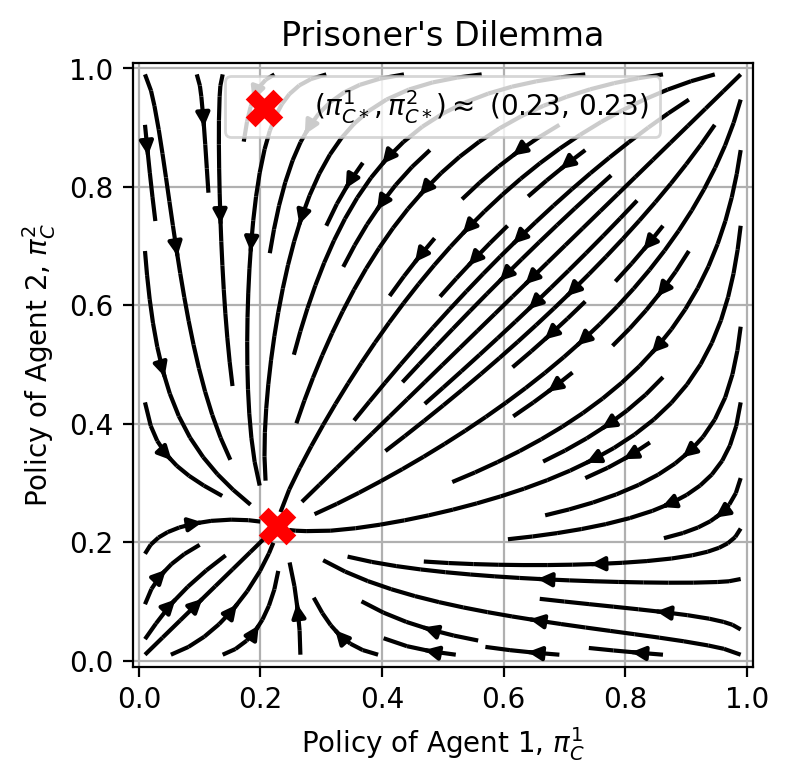

In [3]:
# For the FAQL model 
reward_matrix = reward_matrix_for_two_player_PD # Choose the game here: PD for prisoner's dilemma, MP for matching pennies, SH for stag hunt, BS for bach or stravinsky
dummy, title, first_action = reward_matrix([0, 0], 0, return_title=True)
print(title)
R_i_a1_a2 = np.array([[[reward_matrix([0, 0], 0), reward_matrix([0, 1], 0)], 
                        [reward_matrix([1, 0], 0), reward_matrix([1, 1], 0)]],
                        [[reward_matrix([0, 0], 1), reward_matrix([0, 1], 1)], 
                        [reward_matrix([1, 0], 1), reward_matrix([1, 1], 1)]]
                        ])

# Parameters
learning_rate = 0.01
temperature = 1

# Define the differential equations
def derivatives(p_1_C, p_2_C):
    R_1_CC, R_1_CD, R_1_DC, R_1_DD = R_i_a1_a2[0, 0, 0], R_i_a1_a2[0, 0, 1], R_i_a1_a2[0, 1, 0], R_i_a1_a2[0, 1, 1]
    R_2_CC, R_2_CD, R_2_DC, R_2_DD = R_i_a1_a2[1, 0, 0], R_i_a1_a2[1, 0, 1], R_i_a1_a2[1, 1, 0], R_i_a1_a2[1, 1, 1]
    
    Exp_R_1_C = p_2_C * R_1_CC + (1 - p_2_C) * R_1_CD
    Exp_R_1_D = p_2_C * R_1_DC + (1 - p_2_C) * R_1_DD
    Exp_R_2_C = p_1_C * R_2_CC + (1 - p_1_C) * R_2_DC
    Exp_R_2_D = p_1_C * R_2_CD + (1 - p_1_C) * R_2_DD
    
    p_1_C_derivative = learning_rate / temperature * p_1_C * ( Exp_R_1_C - (p_1_C * Exp_R_1_C + (1 - p_1_C) * Exp_R_1_D) ) + learning_rate * p_1_C * (p_1_C * np.log(p_1_C/p_1_C) + (1 - p_1_C) * np.log((1 - p_1_C) / p_1_C))
    p_2_C_derivative = learning_rate / temperature * p_2_C * ( Exp_R_2_C - (p_2_C * Exp_R_2_C + (1 - p_2_C) * Exp_R_2_D) ) + learning_rate * p_2_C * (p_2_C * np.log(p_2_C/p_2_C) + (1 - p_2_C) * np.log((1 - p_2_C) / p_2_C))
    
    return p_1_C_derivative, p_2_C_derivative

# Create a grid of points in the phase space
Grid_size = int(1e3)
p_1_C_values = np.linspace(0.01, 0.99, Grid_size)
p_2_C_values = np.linspace(0.01, 0.99, Grid_size)
P_1_C, P_2_C = np.meshgrid(p_1_C_values, p_2_C_values)

# Compute the derivatives at each point in the grid
P_1_C_derivative, P_2_C_derivative = derivatives(P_1_C, P_2_C)

# Define the system of equations for the fixed point
def fixed_point_equations(variables):
    p_1_C, p_2_C = variables
    p_1_C_derivative, p_2_C_derivative = derivatives(p_1_C, p_2_C)
    return [p_1_C_derivative, p_2_C_derivative]
# Initial guess for the fixed point
if title == "Prisoner's Dilemma":
    initial_guesses = [[0.5, 0.5]]
elif title == "Matching Pennies":
    initial_guesses = [[0.5, 0.5]]
elif title == "Stag Hunt":
    initial_guesses = [[0.4, 0.4]]
elif title == "Bach or Stravinsky":
    initial_guesses = [[0.2,0.2], [0.5, 0.5], [0.8, 0.8]]
eq_solutions = []
for initial_guess in initial_guesses:
    # Solve the system numerically and get information
    prob_C_1_solution, prob_C_2_solution = np.round(fsolve(fixed_point_equations, initial_guess), 3)
    eq_solutions.append((prob_C_1_solution, prob_C_2_solution))
    print(f"Initial guess: {initial_guess}, Solution: {prob_C_1_solution, prob_C_2_solution}")
# print only the unique solutions
eq_solutions = list(set(eq_solutions))

figsize = (4,4)
dpi = 200
fig3 = plt.figure(figsize=figsize, dpi=dpi)
# streamplot
plt.streamplot(P_1_C, P_2_C, P_1_C_derivative, P_2_C_derivative, color='black', density=0.8)
for eq_solution in eq_solutions:
    plt.scatter(eq_solution[0], eq_solution[1], label=r'$(\pi^1_{C*}, \pi^2_{C*}) \approx$ '+f'({eq_solution[0]:.2f}, {eq_solution[1]:.2f})', marker='x', s=100, linewidth=5, color='red', zorder=11)
plt.xlabel(f'Policy of Agent 1, $\pi^1_{first_action}$')
plt.ylabel(f'Policy of Agent 2, $\pi^2_{first_action}$')
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.title(title)
plt.grid()
plt.legend(loc='upper center')
plt.savefig(f'Figures/FAQL_dynamics/Fig2_II_{title}_Tuyls_streamline_T_{temperature}.pdf', dpi=dpi, bbox_inches='tight')
plt.show()